In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import time
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer, recall_score, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

This dataset from kaggle contains transactions from European credit cardholders collected in the year 2019. https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

In [3]:
##Loading Data set.  Note that data needs to be downloaded and saved in data folder before loading.
fraud = pd.read_csv('data/creditcard.csv')

In [4]:
fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#### Exploratory Analysis

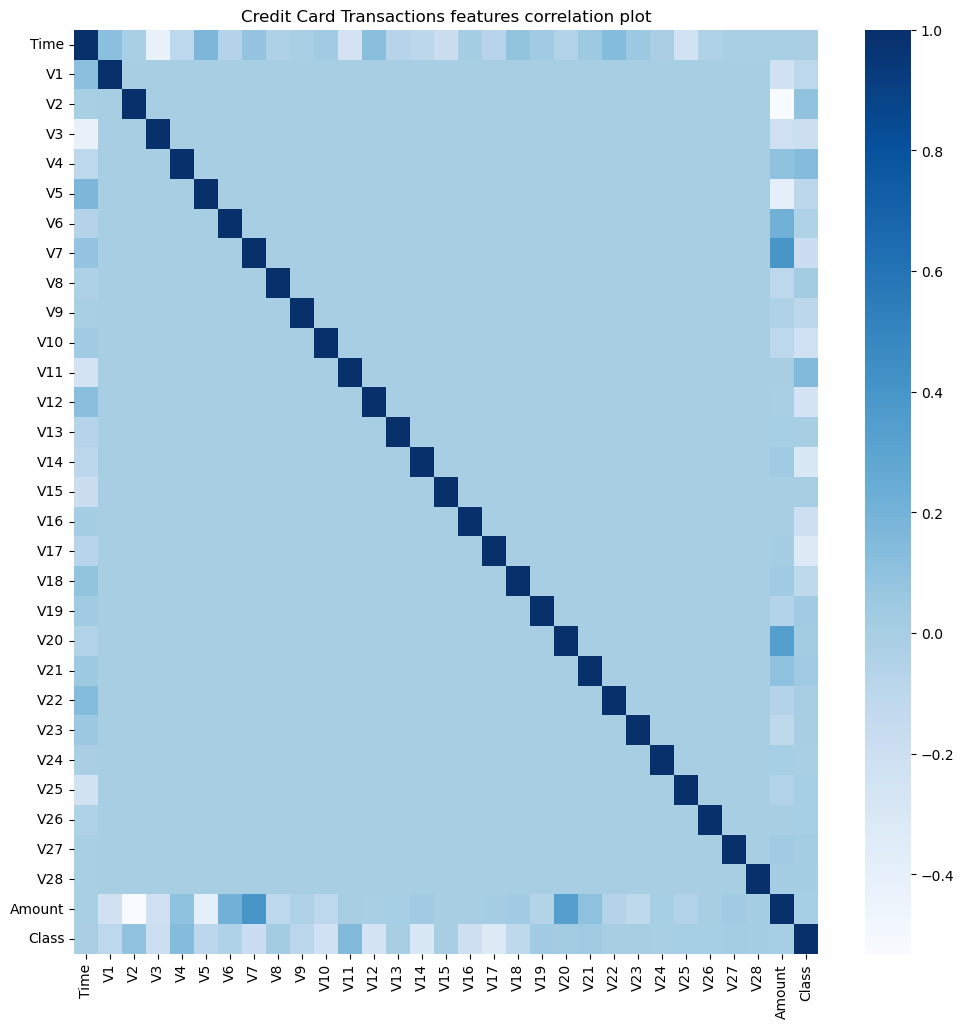

In [28]:
## Plotting correlation of features
plt.figure(figsize=(12, 12))
plt.title('Credit Card Transactions features correlation plot')
sns.heatmap(fraud.corr(), cmap='Blues')
plt.show()

 V2 and V5  have high negative correlation with Amount feature. V7 and V20 shows a correlation with Amount.

In [ ]:
fraud['Class'].value_counts()

In [ ]:
The data set is highly imbalanced. Number of fraud transactions are very small compared to the total number of transactions in the dataset.

Simple plotting will not show the results in the small classes. Using a logarithmic on the Y-axis gives a better visualization. This will highlight the imbalance while still providing meaningful insights. 

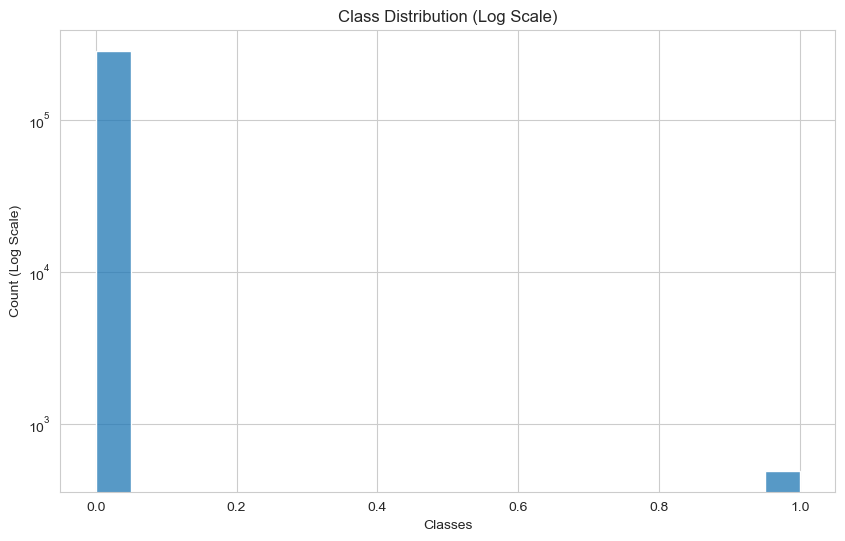

In [97]:
## plotting Class distribution of data
plt.figure(figsize=(10, 6))
sns.histplot(x='Class', data=fraud)
plt.yscale('log')
plt.title('Class Distribution (Log Scale)')
plt.xlabel('Classes')
plt.ylabel('Count (Log Scale)')
plt.show()

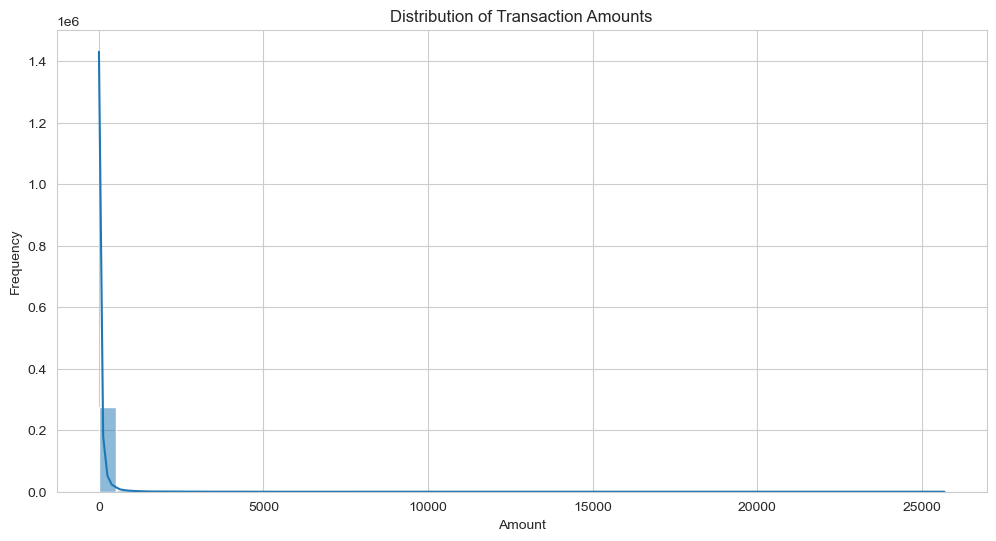

In [98]:
## Plotting Amont feature 
plt.figure(figsize=(12, 6))
sns.histplot(data=fraud, x='Amount', kde=True, bins=50)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

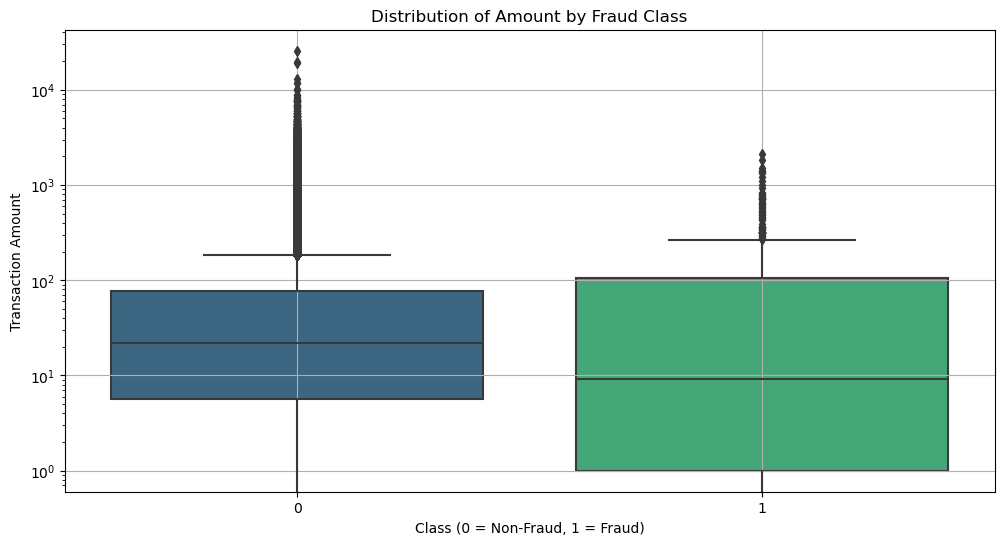

In [10]:
## Plotting Distribution of Amount  and class
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='Amount', data=fraud, palette='viridis')
plt.title('Distribution of Amount by Fraud Class')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Transaction Amount')
plt.yscale('log')  # Use log scale for better visualization of outliers
plt.grid()
plt.show()

In [99]:
## Grouping to a range of Amount bins
fraud['AmountBin'] = pd.cut(fraud['Amount'], bins=[0, 100, 500, 1000, 5000, 10000, float('inf')], labels=['0-100', '100-500', '500-1000', '1000-5000', '5000-10000', '10000+'])
fraud_percentage = fraud.groupby('AmountBin').apply(lambda x: (x['Class'] == 1).mean() * 100).reset_index()
fraud_percentage.columns = ['AmountBin', 'FraudPercentage']


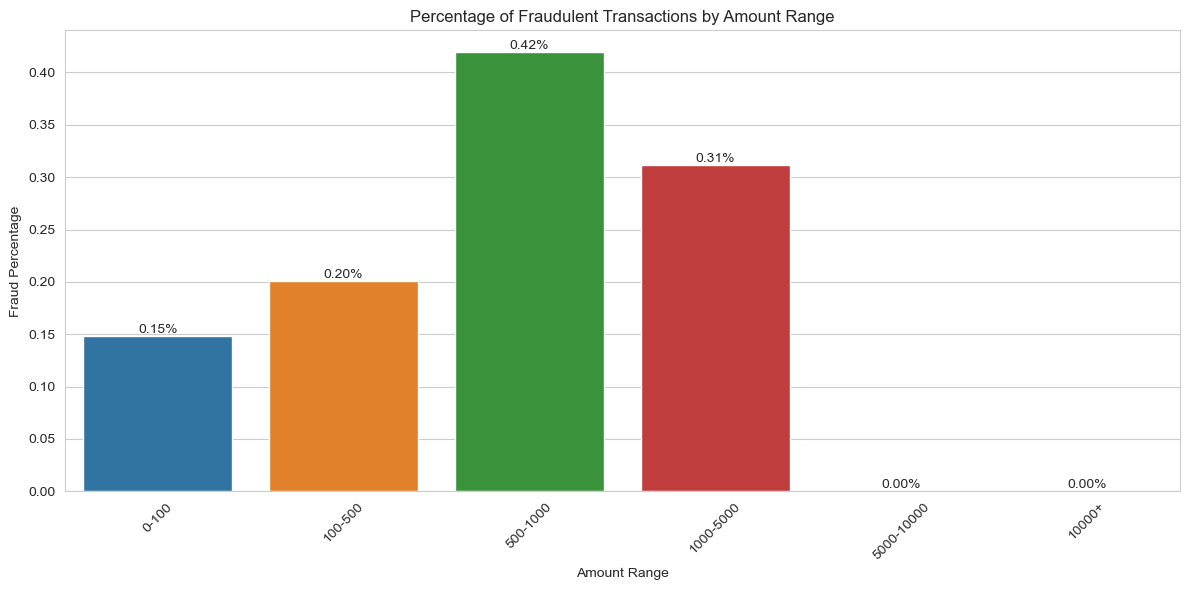

    AmountBin  FraudPercentage
0       0-100         0.147920
1     100-500         0.200566
2    500-1000         0.419220
3   1000-5000         0.311958
4  5000-10000         0.000000
5      10000+         0.000000


In [100]:
## plotting Percentage of transaction by Amount Range
plt.figure(figsize=(12, 6))
sns.barplot(x='AmountBin', y='FraudPercentage', data=fraud_percentage)
plt.title('Percentage of Fraudulent Transactions by Amount Range')
plt.xlabel('Amount Range')
plt.ylabel('Fraud Percentage')
plt.xticks(rotation=45)

for i, v in enumerate(fraud_percentage['FraudPercentage']):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()
print(fraud_percentage)

In [35]:
fraud.drop('AmountBin', axis=1, inplace=True)

In [14]:
corr_matrix = fraud.corr()

##### Calculating correlation without Class field,  Class correlation annotated

In [17]:
corr_matrix_no_class = corr_matrix.drop('Class', axis=1).drop('Class', axis=0)

In [18]:
mask = np.triu(np.ones_like(corr_matrix_no_class, dtype=bool))

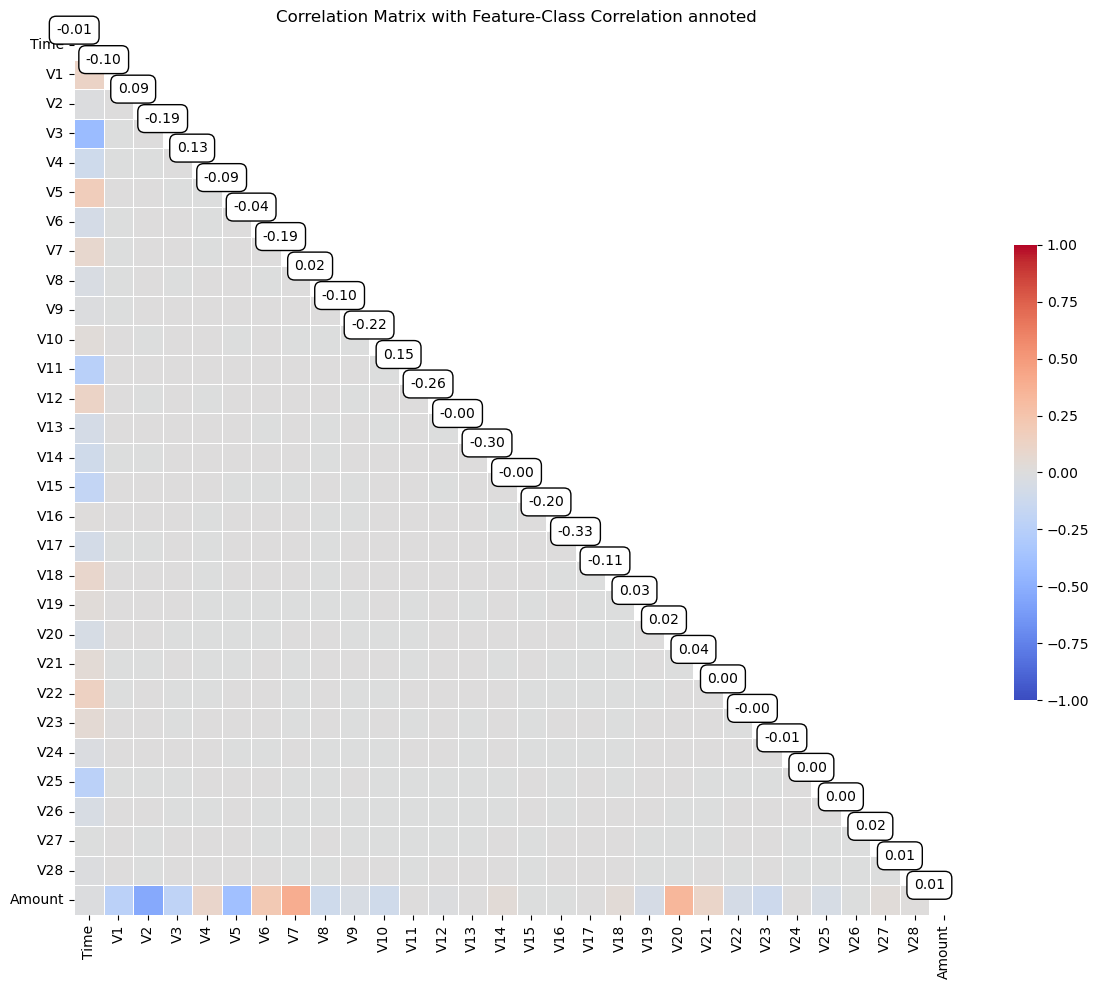

In [36]:

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_no_class, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
for i, feature in enumerate(corr_matrix_no_class.columns):
    correlation = corr_matrix.loc['Class', feature]
    plt.text(i, i, f'{correlation:.2f}', ha='center', va='center', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.title('Correlation Matrix with Feature-Class Correlation annoted')
plt.tight_layout()
plt.show()

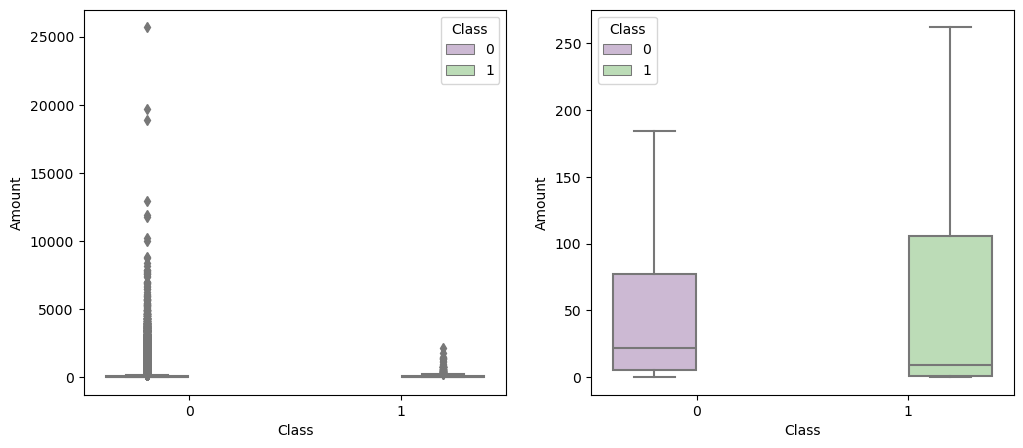

In [37]:
## Amount distribution with and without Outliers
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=fraud, palette="PRGn", showfliers=True) # Displays outliers on the plot
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=fraud, palette="PRGn", showfliers=False) # Hide outliers from the plot
plt.show()

<Figure size 640x480 with 0 Axes>

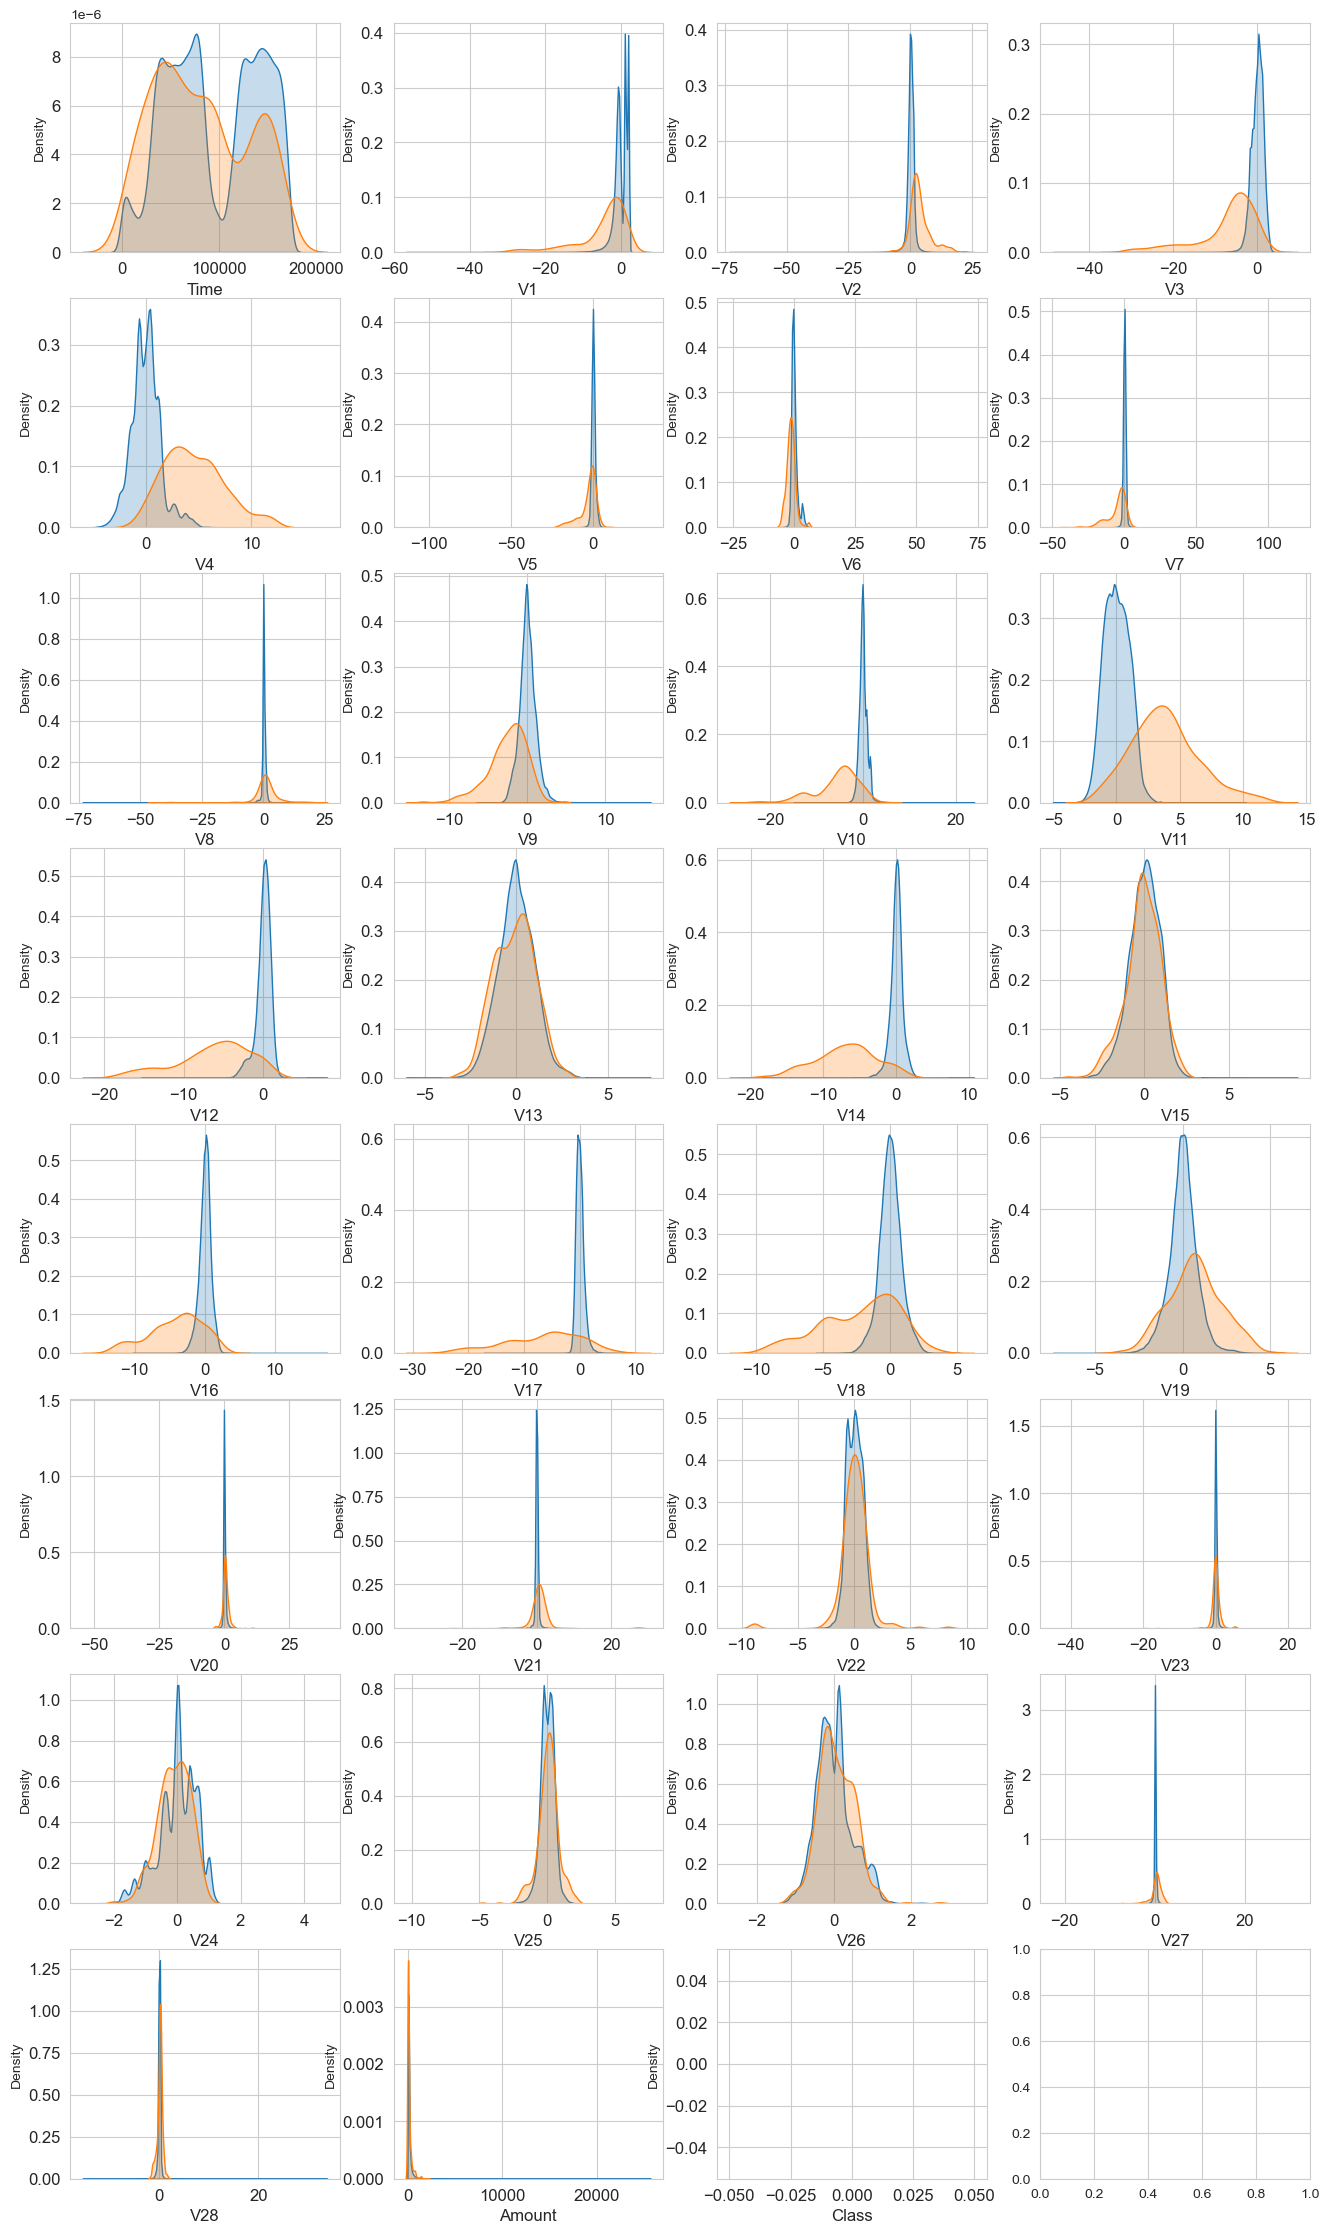

In [96]:
#Feature Density plot
var = fraud.columns.values
i = 0
t0 = fraud.loc[fraud['Class'] == 0]
t1 = fraud.loc[fraud['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], fill=True,label='Non-Fraudulent')
    sns.kdeplot(t1[feature], fill=True, label='Fraudulent')
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [ ]:
V4 and V11 have two seperate distributions for fraud and non fraudulant class. V1, V2, V3, V10 have distinct profile whereas V25, V26, V28 have similar profiles for fraud and non fraudulant. 

In [ ]:
SMOTE is used in this imbalanced dataset so that it will addrsess the class imbalance problem in this dataset. SMOTE interpolate between minority samples and creates a new synthetic samples of minority class. stratify = y ensures that the class distribution is maintatined in both
train and test sets. This is important for imbalanced data. SMOTE is applied only to training data to avoid data leakage. Test remain true representation of real data.

In [48]:
X = fraud.drop('Class', axis =1)
y = fraud['Class']

In [ ]:
## Used stratify=y to maintain class distribution in both train and test. 

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [50]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [64]:
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'{model_name} (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

#### Logistic Regression

In [82]:
lg = LogisticRegression(random_state=42, max_iter = 1000)
lg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [40]:
y_pred = lg.predict(X_test)
y_pred_proba = lg.predict_proba(X_test)[:, 1]

In [28]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

Confusion Matrix:
[[55591  1273]
 [    9    89]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962


ROC AUC Score:
0.970983129816361


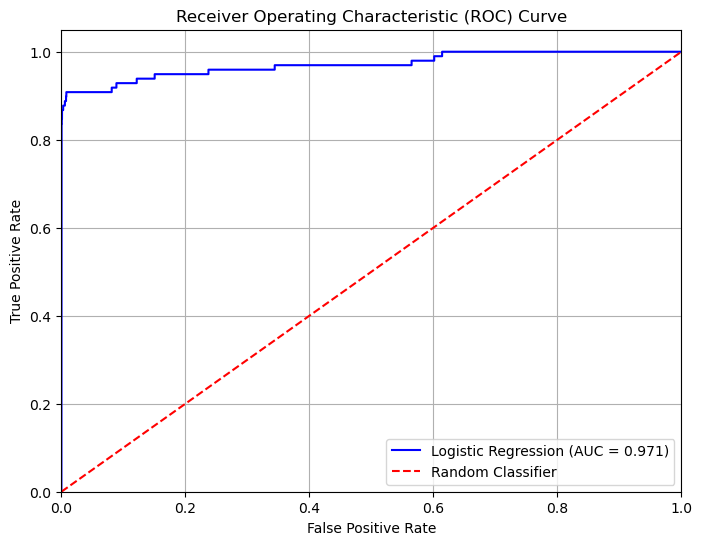

In [45]:
plot_roc_curve(y_test, y_pred_proba, "Logistic Regression")

##### RandomForestClassifier

In [52]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [53]:
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

In [62]:
def print_plot_report(y_test, y_pred, y_pred_proba, model_name):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nROC AUC Score:")
    print(roc_auc_score(y_test, y_pred_proba))

    plot_roc_curve(y_test, y_pred_proba, model_name)

Confusion Matrix:
[[56848    16]
 [   17    81]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score:
0.9644232605112952


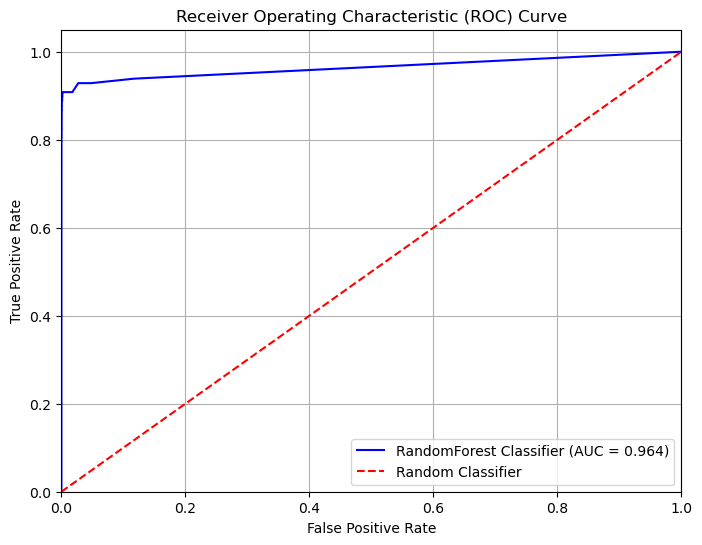

In [51]:
print_plot_report(y_test, y_pred, y_pred_proba, "RandomForest Classifier")

#### Feature Importance with RandomForestClassifier

In [52]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))


Top 10 Important Features:
   feature  importance
14     V14    0.217013
10     V10    0.119797
4       V4    0.116789
12     V12    0.107501
17     V17    0.086248
3       V3    0.070860
11     V11    0.050472
16     V16    0.040096
2       V2    0.038845
9       V9    0.028277


#### Decision Tree

In [66]:
dt = DecisionTreeClassifier()
dt.fit(X_train_resampled, y_train_resampled)


DecisionTreeClassifier()

In [67]:
y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[56771    93]
 [   20    78]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.46      0.80      0.58        98

    accuracy                           1.00     56962
   macro avg       0.73      0.90      0.79     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score:
0.8971414430994682


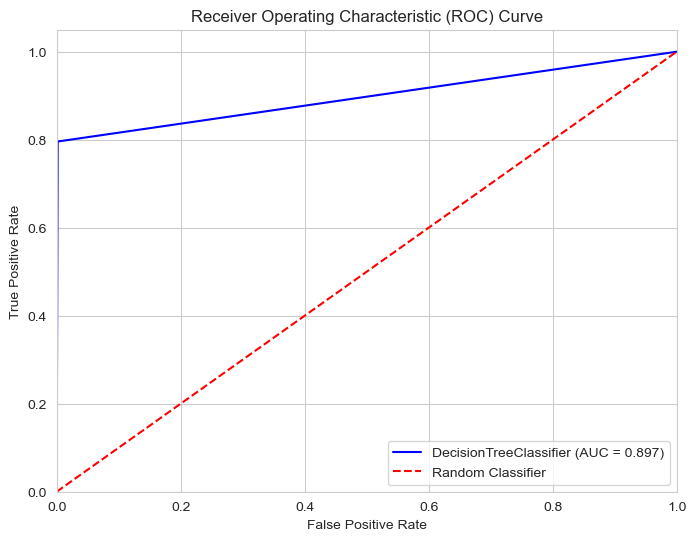

In [68]:
print_plot_report(y_test, y_pred, y_pred_proba, "DecisionTreeClassifier")

#### Randomforest Grid Search

In [89]:
param_grid_rf = {
    "n_estimators": [250, 500, 750],
    "criterion": ["gini", "entropy"],
    "max_features": [3, 5]
}

In [90]:
scorer = make_scorer(recall_score, pos_label=1)

In [91]:
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=3, scoring=scorer, verbose=2)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...criterion=gini, max_features=3, n_estimators=250; total time= 4.4min
[CV] END ...criterion=gini, max_features=3, n_estimators=250; total time= 3.9min
[CV] END ...criterion=gini, max_features=3, n_estimators=250; total time= 3.9min
[CV] END ...criterion=gini, max_features=3, n_estimators=500; total time= 7.8min
[CV] END ...criterion=gini, max_features=3, n_estimators=500; total time= 7.6min
[CV] END ...criterion=gini, max_features=3, n_estimators=500; total time= 7.8min
[CV] END ...criterion=gini, max_features=3, n_estimators=750; total time=11.7min
[CV] END ...criterion=gini, max_features=3, n_estimators=750; total time=11.5min
[CV] END ...criterion=gini, max_features=3, n_estimators=750; total time=11.7min
[CV] END ...criterion=gini, max_features=5, n_estimators=250; total time= 6.8min
[CV] END ...criterion=gini, max_features=5, n_estimators=250; total time= 6.6min
[CV] END ...criterion=gini, max_features=5, n_es

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [3, 5],
                         'n_estimators': [250, 500, 750]},
             scoring=make_scorer(recall_score, pos_label=1), verbose=2)

In [92]:
print("Best parameters:", grid_search_rf.best_params_)
print("Best ROC AUC score:", grid_search_rf.best_score_)

Best parameters: {'criterion': 'gini', 'max_features': 3, 'n_estimators': 250}
Best ROC AUC score: 0.9999912068973097


In [107]:
best_model_rf = grid_search_rf.best_estimator_

In [108]:
y_pred_rf = best_model_rf.predict(X_test)
y_pred_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[56849    15]
 [   15    83]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.85      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score:
0.9862714869994142


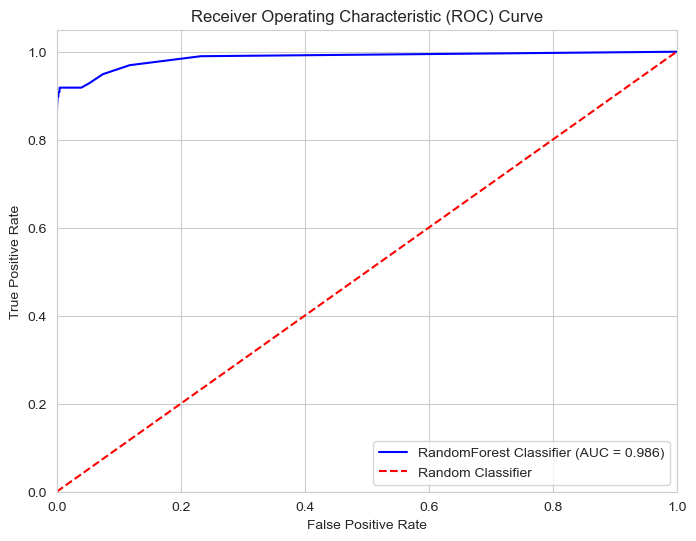

In [109]:
print_plot_report(y_test, y_pred_rf, y_pred_proba_rf, "RandomForest Classifier")

In [110]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))


Top 10 Important Features:
   feature  importance
14     V14    0.132865
4       V4    0.130017
12     V12    0.092616
10     V10    0.088679
17     V17    0.082571
3       V3    0.072611
11     V11    0.055231
16     V16    0.054769
2       V2    0.040562
7       V7    0.036699


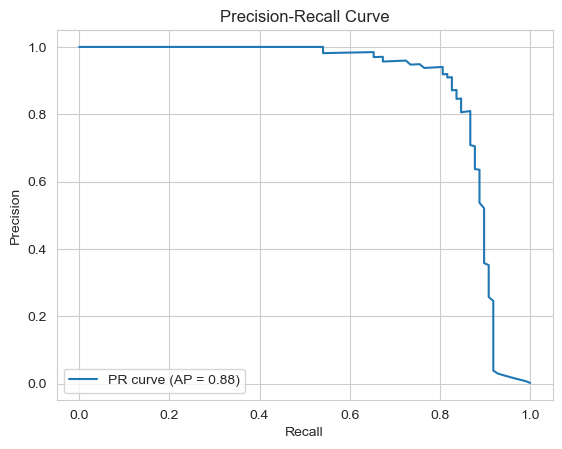

In [116]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_rf)
pr_auc = average_precision_score(y_test, y_pred_proba_rf)

plt.figure()
plt.plot(recall, precision, label=f'PR curve (AP = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

#### Decision Tree Grid Search

In [72]:
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

In [73]:
grid_search_dt = GridSearchCV(dt, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_dt.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [74]:
best_model_dt = grid_search_dt.best_estimator_

In [75]:
y_pred = best_model_dt.predict(X_test)
y_pred_proba = best_model_dt.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[56230   634]
 [   17    81]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.83      0.20        98

    accuracy                           0.99     56962
   macro avg       0.56      0.91      0.60     56962
weighted avg       1.00      0.99      0.99     56962


ROC AUC Score:
0.9149539036210995


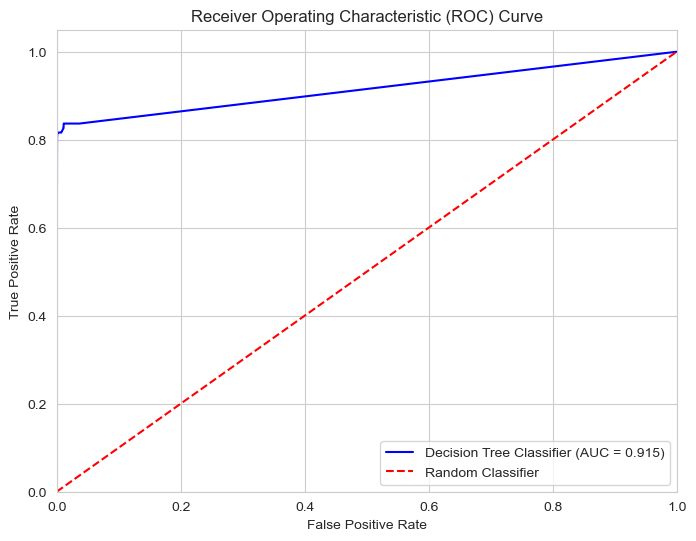

In [76]:
print_plot_report(y_test, y_pred, y_pred_proba, "Decision Tree Classifier")

#### Logistic Regression Grid Search

In [117]:
param_grid_lg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

In [121]:
grid_search_lg = GridSearchCV(LogisticRegression(random_state=42, max_iter = 8000), 
                           param_grid_lg, 
                           cv=3, 
                           scoring='roc_au', 
                           n_jobs=-1)
grid_search_lg.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=8000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc')

In [123]:
best_model_lg = grid_search_lg.best_estimator_
y_pred = best_model_lg.predict(X_test)
y_pred_proba = best_model_lg.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[56294   570]
 [   10    88]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962


ROC AUC Score:
0.9763652876035052


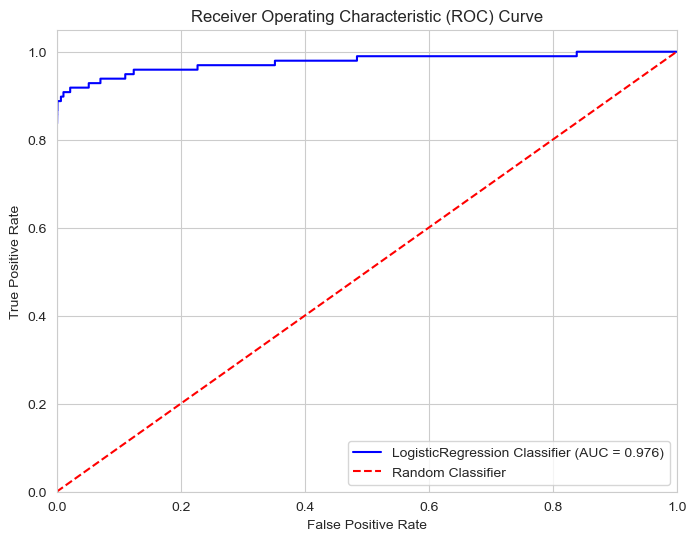

In [124]:
print_plot_report(y_test, y_pred, y_pred_proba, "LogisticRegression Classifier")